##  Predict the sequence of vehicle controls to achieve a desired vehicle state given a current vehicle state


f(state1,state2) -> control

Import the packages

In [107]:
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
os.makedirs('plots',exist_ok=True)
pd.set_option('display.max_columns', None)


build a merged dataframe to easily access the data. Chose to merge the control based on most recent input. The reason for this is that the control between state timestamps indicated consistant controls accross many data points, indicating duplicity. As a result, the most recent control to the state timestamp is attatched, otherwise it is truncated.

In [108]:
AHRS = pd.read_csv('ahrs.csv')
CONTROL = pd.read_csv('vehicle_control.csv')

AHRS['ts'] = pd.to_datetime(AHRS['ts'])
CONTROL['ts'] = pd.to_datetime(CONTROL['ts'])
merged_df = pd.merge_asof(AHRS,CONTROL, on='ts',direction='backward')
# state_cols = list(AHRS.columns)
# state_cols.remove('ts')

AHRS_COLS = list(AHRS.columns.drop('ts'))
NEXT_AHRS_COLS = [col+"_next" for col in AHRS_COLS]
CONTROL_COLS = list(CONTROL.columns.drop('ts'))
for col in AHRS_COLS:
    merged_df[col + "_next"] = merged_df[col].shift(-1)

merged_df = merged_df.dropna()
display(merged_df.head())
print(CONTROL_COLS)
print(AHRS_COLS)




,ts,roll_deg,pitch_deg,yaw_deg,ax_mps2,ay_mps2,az_mps2,omega_x_dps,omega_y_dps,omega_z_dps,ve_mps,vn_mps,vu_mps,gear,throttle,trim,turn,roll_deg_next,pitch_deg_next,yaw_deg_next,ax_mps2_next,ay_mps2_next,az_mps2_next,omega_x_dps_next,omega_y_dps_next,omega_z_dps_next,ve_mps_next,vn_mps_next,vu_mps_next
1,2024-07-31 14:05:00.092972588+00:00,0.071586,-1.813645,340.940125,-9.969663,0.094937,-0.338713,-0.11750,-0.10375,-0.44750,-0.000357,0.000355,0.002445,0.0,0.008547,2.0,0.003663,0.070876,-1.813810,340.938721,-9.963537,0.140262,-0.315438,-0.05125,-0.22125,-0.41750,-0.000010,0.000226,0.000702
2,2024-07-31 14:05:00.113763246+00:00,0.070876,-1.813810,340.938721,-9.963537,0.140262,-0.315438,-0.05125,-0.22125,-0.41750,-0.000010,0.000226,0.000702,0.0,0.008547,2.0,0.003663,0.070295,-1.813962,340.939148,-9.992325,0.100450,-0.323400,-0.04250,-0.17250,-0.39125,-0.000253,0.000390,0.000410
3,2024-07-31 14:05:00.133055196+00:00,0.070295,-1.813962,340.939148,-9.992325,0.100450,-0.323400,-0.04250,-0.17250,-0.39125,-0.000253,0.000390,0.000410,0.0,0.008547,2.0,0.003663,0.070045,-1.814164,340.939636,-10.025400,0.109637,-0.335650,-0.14375,-0.17375,-0.36750,-0.000029,0.000404,0.000288
4,2024-07-31 14:05:00.153150190+00:00,0.070045,-1.814164,340.939636,-10.025400,0.109637,-0.335650,-0.14375,-0.17375,-0.36750,-0.000029,0.000404,0.000288,0.0,0.008547,2.0,0.003663,0.070483,-1.814484,340.939484,-10.099512,0.073500,-0.355863,-0.13750,-0.19625,-0.42375,0.000196,0.000485,0.000386
5,2024-07-31 14:05:00.172988544+00:00,0.070483,-1.814484,340.939484,-10.099512,0.073500,-0.355863,-0.13750,-0.19625,-0.42375,0.000196,0.000485,0.000386,0.0,0.008547,2.0,0.003663,0.070457,-1.814585,340.939148,-10.113600,0.088812,-0.332588,-0.11000,-0.19125,-0.46625,0.000439,0.000571,0.000511


['gear', 'throttle', 'trim', 'turn']
['roll_deg', 'pitch_deg', 'yaw_deg', 'ax_mps2', 'ay_mps2', 'az_mps2', 'omega_x_dps', 'omega_y_dps', 'omega_z_dps', 've_mps', 'vn_mps', 'vu_mps']


Below is a Custom Class to wrap 2 different models. The modifiers include fit, predict, and predictfromDF

In [155]:
# format is[state{t}, state{t+1}]
X = merged_df[AHRS_COLS + NEXT_AHRS_COLS].values
sample = merged_df.sample(n=1) 
display(sample)

,ts,roll_deg,pitch_deg,yaw_deg,ax_mps2,ay_mps2,az_mps2,omega_x_dps,omega_y_dps,omega_z_dps,ve_mps,vn_mps,vu_mps,gear,throttle,trim,turn,roll_deg_next,pitch_deg_next,yaw_deg_next,ax_mps2_next,ay_mps2_next,az_mps2_next,omega_x_dps_next,omega_y_dps_next,omega_z_dps_next,ve_mps_next,vn_mps_next,vu_mps_next
249135,2024-07-31 15:28:02.767597700+00:00,-4.473779,4.083384,33.731464,-8.853075,0.626587,1.267262,-1.89375,5.84,0.085,6.267377,9.706901,-0.148649,1.0,0.45,0.0,-0.011948,-4.456471,3.975453,33.70467,-9.602163,-1.740113,2.123537,-1.9175,3.44,0.585,6.254579,9.728993,-0.168488


In [156]:
class MixedRandomForest:
    def __init__(self, metric:str):
        os.makedirs("Control Models",exist_ok=True)
        self.metric = metric.lower().strip()
        if metric == 'throttle' or metric == 'turn':
            self.model = RandomForestRegressor(n_estimators=100, n_jobs=-1) # throttle, turn
        elif metric == 'trim' or metric == 'gear':
            self.model = RandomForestClassifier(n_estimators=100,n_jobs=-1) # trim, gear
        else:
            raise Exception("The metric to train is not valid. Must be throttle,turn,gear, or trim")
        self.model_path = f"Control Models/{self.metric}_model.pkl"
        self.is_fitted = os.path.exists(self.model_path)

    def fit(self, X, y):
        # fits or loads the prevously trained model
        if os.path.exists(self.model_path):
            print("loading instead of training...")
            self.model = joblib.load(self.model_path)
            self.is_fitted = True
        else:
            print(f"Training new model for '{self.metric}'...")
            self.model.fit(X, y)
            self.is_fitted = True
            joblib.dump(self.model, self.model_path)
            print(f"Model saved to '{self.model_path}'")
            return self
        
    def predict(self,X):
        # given X, a row vector of inputs outputs raw control
        self.model = joblib.load(self.model_path)
        return self.model.predict(X)

    def predictfromDF(self, row_df, decimal_places=4):
        # given a row of the merged dataframe, outputs a tuple of atual,predicted
        if not self.is_fitted:
            raise Exception("Model must be fitted first.")

        # Ensure DataFrame shape
        if isinstance(row_df, pd.Series):
            row_df = row_df.to_frame().T
        elif not isinstance(row_df, pd.DataFrame):
            raise TypeError("Expected a pandas Series or DataFrame.")

       
        s_t = row_df[AHRS_COLS].values
        s_tp1 = row_df[NEXT_AHRS_COLS].values
        x_input = np.hstack([s_t, s_tp1])

        preds = np.array(self.model.predict(x_input)).reshape(-1) # shape issue?
        actuals = np.array(row_df[self.metric].values).reshape(-1)
        # print(preds.shape)
        #print(preds)

        # Format predictions
        if self.metric in {'gear', 'trim'}:
            preds = preds.astype(int)
        else:
            preds = np.round(preds, decimals=decimal_places)

        if self.metric in {'gear', 'trim'}:
            actuals = actuals.astype(int)
        else:
            actuals = np.round(actuals, decimals=decimal_places)

        # Return (pred, actual) pairs
        return np.stack((preds, actuals), axis=-1)


In [157]:
os.makedirs('plots/Control Plots',exist_ok=True)

## Predict Gear

In [158]:
y_gear = merged_df['gear'].values
XGear_train, XGear_test, yGear_train, yGear_test = train_test_split(X, y_gear, test_size=0.3)
Gear = MixedRandomForest('gear')
Gear.fit(XGear_train, yGear_train)

loading instead of training...


In [159]:
Gear.predictfromDF(sample)

array([[1, 1]])

In [160]:
print("Gear (Classification)")
Geartrain_pred = Gear.predict(XGear_train)
Geartest_pred = Gear.predict(XGear_test)
print(f"  Train Accuracy: {accuracy_score(yGear_train, Geartrain_pred):.2%}")
print(f"  Test  Accuracy: {accuracy_score(yGear_test, Geartest_pred):.2%}")

Gear (Classification)
  Train Accuracy: 99.98%
  Test  Accuracy: 99.98%


<Figure size 600x600 with 0 Axes>

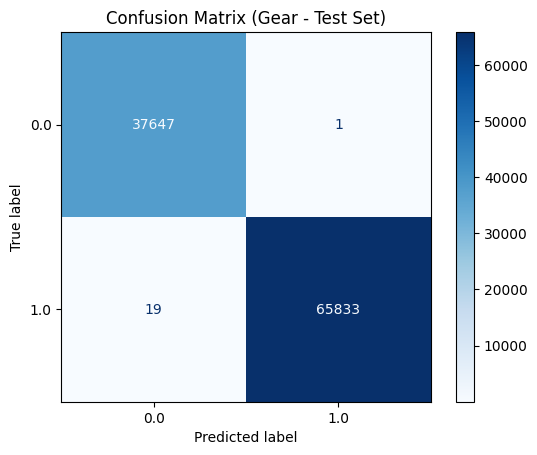

In [161]:
cm = confusion_matrix(yGear_test, Geartest_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Gear.model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Gear - Test Set)")
plt.grid(False)
plt.savefig("plots/Control Plots/Gear")
plt.show()

## Predict Throttle

In [162]:
y_throttle = merged_df['throttle'].values
XThrottle_train, XThrottle_test, yThrottle_train, yThrottle_test = train_test_split(X, y_throttle, test_size=0.3)
Throttle = MixedRandomForest('throttle')
Throttle.fit(XThrottle_train, yThrottle_train)


loading instead of training...


In [163]:
Throttle.predictfromDF(sample)

array([[0.45, 0.45]])

In [178]:
print("Throttle (Regression)")
Throttle_train_pred = Throttle.predict(XThrottle_train)
Throttle_test_pred = Throttle.predict(XThrottle_test)
print(f"Train MSE: {mean_squared_error(yThrottle_train, Throttle_train_pred):.6f}")
print(f"Test  MSE: {mean_squared_error(yThrottle_test, Throttle_test_pred):.6f}")
print()

Throttle (Regression)
Train MSE: 0.000051
Test  MSE: 0.000041



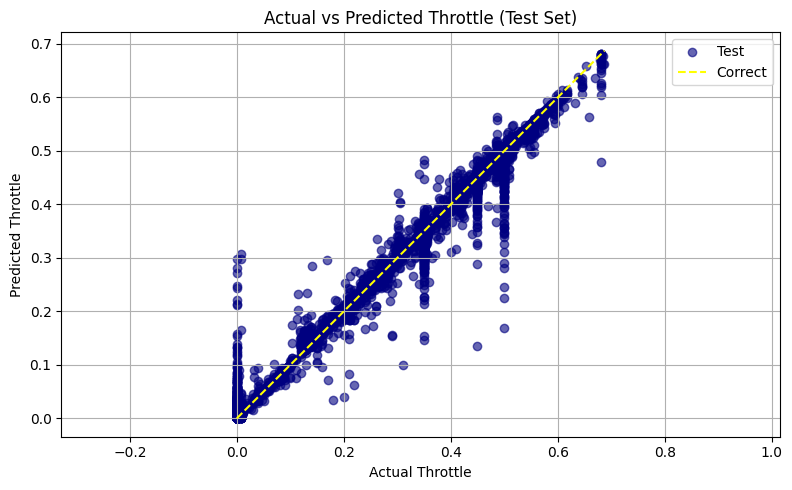

In [165]:
min_val = min(yThrottle_test.min(), Throttle_test_pred.min())
max_val = max(yThrottle_test.max(), Throttle_test_pred.max())

plt.figure(figsize=(8, 5))
plt.scatter(yThrottle_test, Throttle_test_pred, alpha=0.6, label='Test',color='navy')
plt.plot([min_val, max_val], [min_val, max_val], '--', label='Correct', color='yellow')

plt.xlabel('Actual Throttle')
plt.ylabel('Predicted Throttle')
plt.title('Actual vs Predicted Throttle (Test Set)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"plots/Control Plots/Throttle")
plt.show()


## Predict Trim

In [166]:
y_trim = merged_df['trim'].values
XTrim_train, XTrim_test, yTrim_train, yTrim_test = train_test_split(X, y_trim, test_size=0.3)
Trim = MixedRandomForest('trim')
Trim.fit(XTrim_train, yTrim_train)

loading instead of training...


In [167]:
Trim.predictfromDF(sample)

array([[0, 0]])

In [168]:
print("Trim (Classification)")
Trim_train_pred = Trim.predict(XTrim_train)
Trim_test_pred = Trim.predict(XTrim_test)
print(f"Train Accuracy: {accuracy_score(yTrim_train, Trim_train_pred):.2%}")
print(f"Test  Accuracy: {accuracy_score(yTrim_test, Trim_test_pred):.2%}")
print()

Trim (Classification)
Train Accuracy: 99.97%
Test  Accuracy: 99.98%



<Figure size 600x600 with 0 Axes>

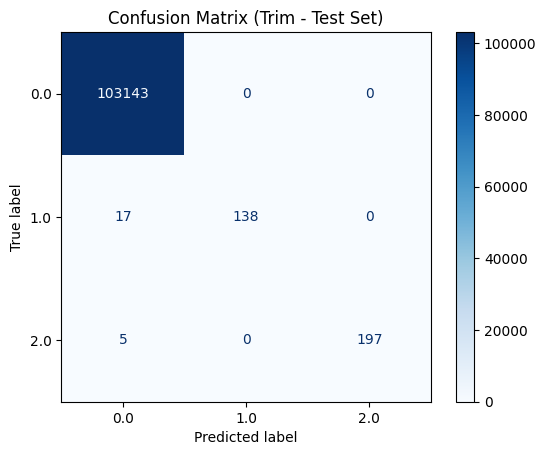

In [169]:

# Plot confusion matrix for test data
cm = confusion_matrix(yTrim_test, Trim_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Trim.model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Trim - Test Set)")
plt.grid(False)
plt.savefig("plots/Control Plots/Trim")
plt.show()


## Predict Turn

In [170]:
y_turn = merged_df['turn'].values
XTurn_train, XTurn_test, yTurn_train, yTurn_test = train_test_split(X, y_turn, test_size=0.3)
Turn = MixedRandomForest('turn')
Turn.fit(XTurn_train, yTurn_train)

loading instead of training...


In [171]:
Turn.predictfromDF(sample)

array([[-0.0078, -0.0119]])

In [172]:
print("Turn (Regression)")
Turn_train_pred = Turn.predict(XTurn_train)
Turn_test_pred = Turn.predict(XTurn_test)
print(f"  Train MSE: {mean_squared_error(yTurn_train, Turn_train_pred):.6f}")
print(f"  Test  MSE: {mean_squared_error(yTurn_test, Turn_test_pred):.6f}")
print()

Turn (Regression)
  Train MSE: 0.000351
  Test  MSE: 0.000406



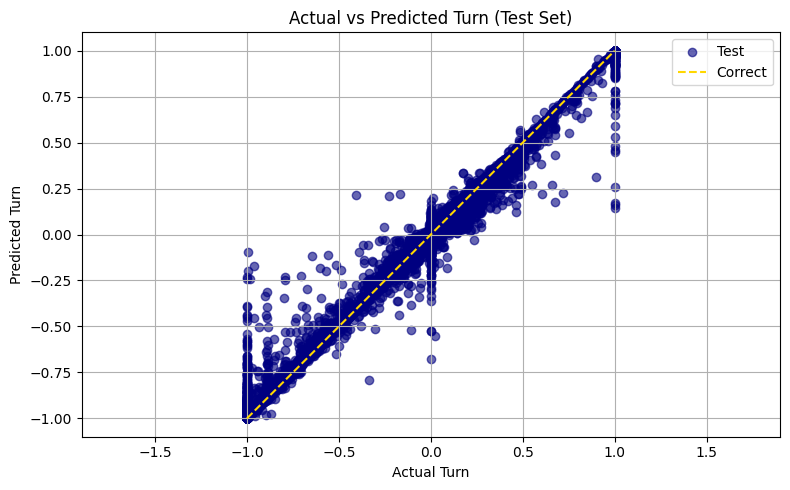

In [173]:
min_val = min(yTurn_test.min(), Turn_test_pred.min())
max_val = max(yTurn_test.max(), Turn_test_pred.max())

plt.figure(figsize=(8, 5))
plt.scatter(yTurn_test, Turn_test_pred, alpha=0.6, label='Test',color='navy')
plt.plot([min_val, max_val], [min_val, max_val], '--', label='Correct', color='gold')

plt.xlabel('Actual Turn')
plt.ylabel('Predicted Turn')
plt.title('Actual vs Predicted Turn (Test Set)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"plots/Control Plots/Turn")
plt.show()

## Below is a side-by-side comparison of actual vs predicted metrics

In [174]:

# display(sample)
# print(predict_throttle_from_row(sample))
# print(predict_turn_from_row(sample))
# print(predict_trim_from_row(sample))
# print(predict_gear_from_row(sample))

def evaluate_prediction_from_row(row_df, decimal_places=4):
    """
    row_df is a row of the merged dataframe. Function displays compairson of actual v predicted,current vs next state,
    error rates.
    """
    if isinstance(row_df, pd.Series):
        row_df = row_df.to_frame().T

    # Predict all 4 controls
    pred_throttle, actual_throttle = Throttle.predictfromDF(row_df)[0]
    pred_turn, actual_turn = Turn.predictfromDF(row_df)[0]
    pred_trim, actual_trim = Trim.predictfromDF(row_df)[0]
    pred_gear, actual_gear = Gear.predictfromDF(row_df)[0]

    # Compute errors
    throttle_error = round(pred_throttle - actual_throttle, decimal_places)
    turn_error = round(pred_turn - actual_turn, decimal_places)

    def percent_error(pred, actual):
        return round(abs((pred - actual) / (actual + 1e-6)) * 100, 2) if actual != 0 else 0.0

    throttle_pct_error = percent_error(pred_throttle, actual_throttle)
    turn_pct_error = percent_error(pred_turn, actual_turn)

    # Build output DataFrame
    current_state = row_df[AHRS_COLS] 
    next_state = row_df[NEXT_AHRS_COLS] 
    next_state.columns = AHRS_COLS 


    control_actual = pd.DataFrame([{
        'throttle': actual_throttle,
        'turn': actual_turn,
        'trim': actual_trim,
        'gear': actual_gear
    }], index=['Actual'])

    control_pred = pd.DataFrame([{
        'throttle': pred_throttle,
        'turn': pred_turn,
        'trim': pred_trim,
        'gear': pred_gear
    }], index=['Predicted'])

    control_error = pd.DataFrame([{
        'throttle_error': throttle_error,
        'throttle_pct_error': f"{throttle_pct_error}%",
        'turn_error': turn_error,
        'turn_pct_error': f"{turn_pct_error}%",
        'trim_correct': pred_trim == actual_trim,
        'gear_correct': pred_gear == actual_gear
    }], index=['Error'])

    # Display
    current_state_df = current_state.T
    next_state_df = next_state.T

    # Concatenate side-by-side
    state_side_by_side = pd.concat([current_state_df, next_state_df], axis=1)
    state_side_by_side.columns = ['Current State', 'Next State']  # Optional column labels

    # Display them together
    display(state_side_by_side)

    print("Control Comparison:")
    display(pd.concat([control_actual, control_pred]))

    print("Errors:")
    display(control_error)
sample = merged_df.sample(n=1) 
evaluate_prediction_from_row(sample)


,Current State,Next State
roll_deg,-5.052570,-5.032652
pitch_deg,1.266525,1.342461
yaw_deg,351.290375,351.313873
ax_mps2,-11.584825,-9.145238
ay_mps2,-0.932225,-0.282975
az_mps2,-0.480813,1.112912
omega_x_dps,1.387500,1.355000
omega_y_dps,-3.915000,-2.486250
omega_z_dps,0.580000,0.112500
ve_mps,-1.848835,-1.847247


Control Comparison:


,throttle,turn,trim,gear
Actual,0.45,-0.0259,0,1
Predicted,0.45,-0.0262,0,1


Errors:


,throttle_error,throttle_pct_error,turn_error,turn_pct_error,trim_correct,gear_correct
Error,0.0,0.0%,-0.0003,1.16%,True,True


## For 100 random samples in the data, let's see how the model does

In [ ]:
throttle_errors = []
throttle_pct_errors = []
turn_errors = []
turn_pct_errors = []
gear_correct = []
trim_correct = []

sample_df = merged_df.sample(n=100)

for i in tqdm(range(len(sample_df)), desc=f"Evaluating {len(sample_df)} samples..."):
    row = sample_df.iloc[i:i+1]  # always a DataFrame
    pred_throttle, actual_throttle = Throttle.predictfromDF(row)[0]
    pred_turn, actual_turn = Turn.predictfromDF(row)[0]
    pred_trim, actual_trim = Trim.predictfromDF(row)[0]
    pred_gear, actual_gear = Gear.predictfromDF(row)[0]

    # Collect errors
    throttle_errors.append(abs(pred_throttle - actual_throttle))
    turn_errors.append(abs(pred_turn - actual_turn))

    def pct_error(pred, actual):
        return abs((pred - actual) / (actual + np.finfo(float).eps)) * 100 if actual != 0 else 0.0

    throttle_pct_errors.append(pct_error(pred_throttle, actual_throttle))
    turn_pct_errors.append(pct_error(pred_turn, actual_turn))

    gear_correct.append(pred_gear == actual_gear)
    trim_correct.append(pred_trim == actual_trim)

#  averages
avg_throttle_error = round(sum(throttle_errors) / len(throttle_errors), 4)
avg_turn_error = round(sum(turn_errors) / len(turn_errors), 4)
avg_throttle_pct_error = round(sum(throttle_pct_errors) / len(throttle_pct_errors), 2)
avg_turn_pct_error = round(sum(turn_pct_errors) / len(turn_pct_errors), 2)
gear_accuracy = round(sum(gear_correct) / len(gear_correct) * 100, 2)
trim_accuracy = round(sum(trim_correct) / len(trim_correct) * 100, 2)

# show summary
summary_df = pd.DataFrame([{
    'Avg Throttle Error': avg_throttle_error,
    'Avg Throttle % Error': f"{avg_throttle_pct_error}%",
    'Avg Turn Error': avg_turn_error,
    'Avg Turn % Error': f"{avg_turn_pct_error}%",
    'Gear Accuracy': f"{gear_accuracy}%",
    'Trim Accuracy': f"{trim_accuracy}%"
}])

display(summary_df) 

Evaluating 100 samples...:   0%|          | 0/100 [00:00<?, ?it/s]

,Avg Throttle Error,Avg Throttle % Error,Avg Turn Error,Avg Turn % Error,Gear Accuracy,Trim Accuracy
0,0.0006,0.05%,0.0026,40.6%,100.0%,99.0%


Let's see what features are important to the model

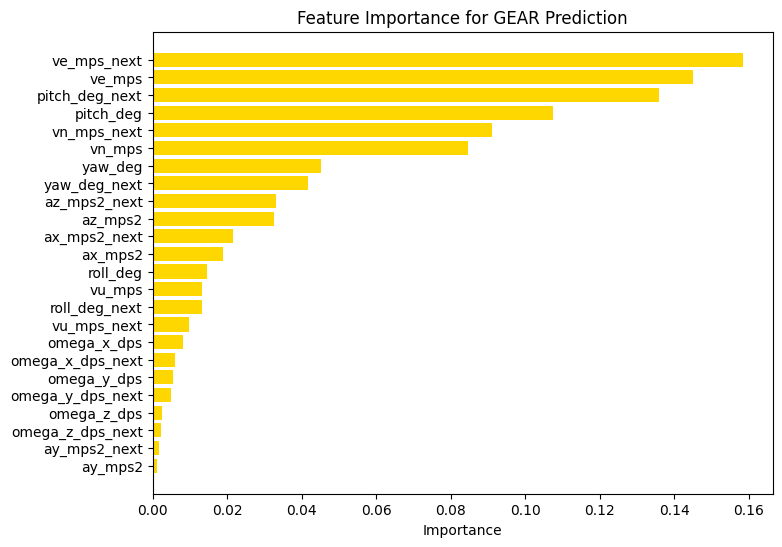

Saved importance plot: plots/Control Importances/Importance_of_GEAR.png


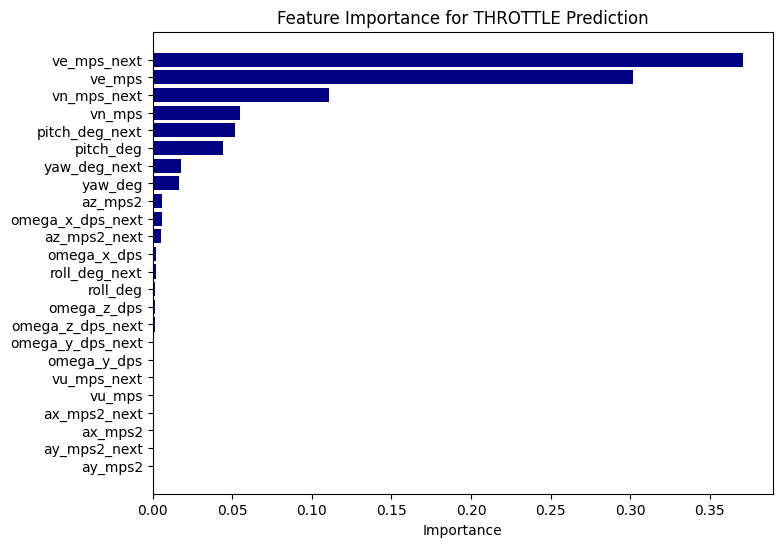

Saved importance plot: plots/Control Importances/Importance_of_THROTTLE.png


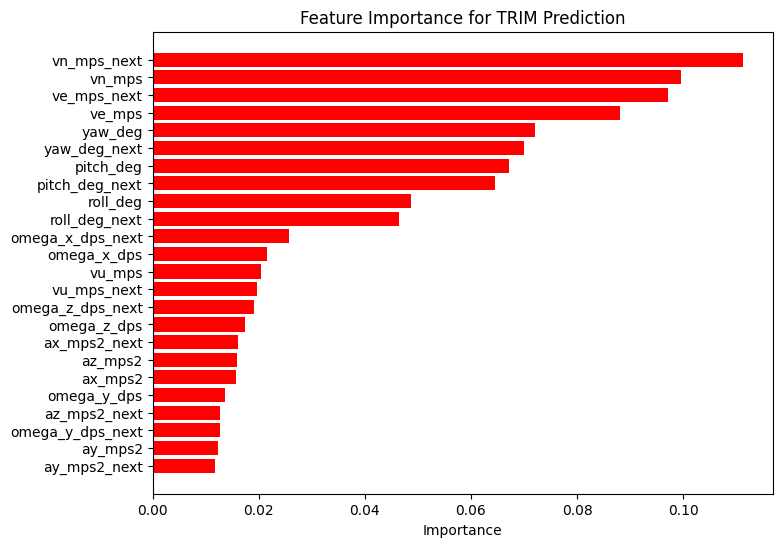

Saved importance plot: plots/Control Importances/Importance_of_TRIM.png


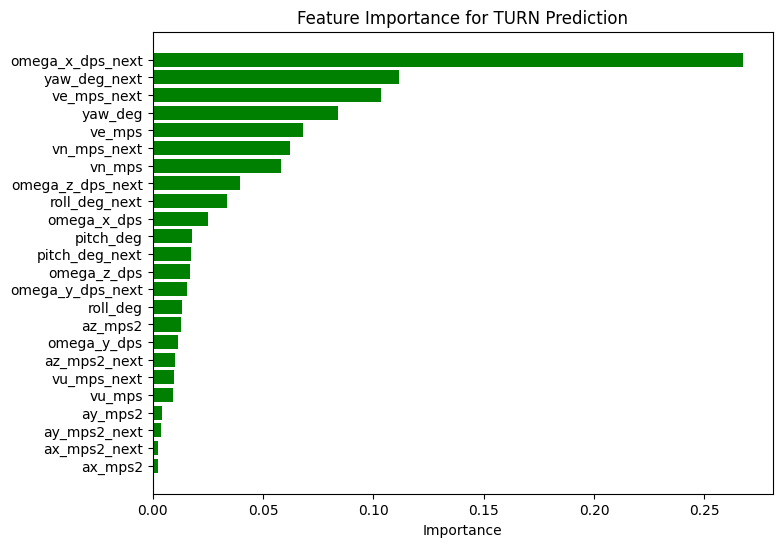

Saved importance plot: plots/Control Importances/Importance_of_TURN.png


In [ ]:
feature_names = AHRS_COLS + NEXT_AHRS_COLS
os.makedirs("plots/Control Importances", exist_ok=True)
for i, predictor in enumerate([Gear, Throttle, Trim, Turn]):
    importances = predictor.model.feature_importances_
    #print(importances.sum())
    importances_percent = importances / importances.sum() # for safety, already summing to 1
    
    importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_percent
    }).sort_values(by='Importance', ascending=False)    
    colors = ['gold', 'navy', 'red', 'green']
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors[i])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance for {CONTROL_COLS[i].upper()} Prediction')
    plt.gca().invert_yaxis()
    
    #save
    plot_path = os.path.join("plots", "Control Importances", f"Importance_of_{CONTROL_COLS[i].upper()}.png")
    plt.savefig(plot_path, bbox_inches='tight')
    plt.show()  # Close to avoid overlap in next plot

    print(f"Saved importance plot: {plot_path}")